In [19]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [166]:


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs



def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()





def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).mean()


In [180]:
exp_dir = Path('/Users/dashiell/workspace/sn-grok/experiments')


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()





def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).mean()


def full_ablations(model_seed, data_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/experiments')
    run_name = f'model_{model_seed}_data_{data_seed}'
    #run_name = Path('s5_lr1e-5_5')

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(ckpt_dir / f'data_{ds}.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    
    abs_logits = model.unembed(linear_acts.abs())
    abs_loss = loss_fn(abs_logits, targets).mean()
    
    full_sign_logits = model.unembed(relu(-1. * linear_acts))
    full_sign_loss = loss_fn(full_sign_logits, targets).mean()
    
    fmodel, params = functorch.make_functional(model)
    
    fparams = [deepcopy(p) for p in params]
    fparams[0] = -1.0 * params[0]
    
    left_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    fparams = [deepcopy(p) for p in params]
    fparams[1] = -1.0 * params[1]
    
    right_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    return {
        'model_seed': model_seed,
        'data_seed': data_seed,
        'original_loss': original_loss.item(),
        'full_sign_loss': full_sign_loss.item(),
        'abs_loss': abs_loss.item(),
        'left_sign_loss':  left_sign_loss.item(),
        'right_sign_loss': right_sign_loss.item()
    }
    



In [181]:
model_seeds = [0, 1, 2, 3, 4, 5, 6, 7]
data_seeds = [10, 11, 12, 13, 14, 15, 16, 17]

full_ablations_data = []
for ms, ds in product(model_seeds, data_seeds):
    full_ablations_data.append(full_ablations(ms, ds))
data = pl.DataFrame(full_ablations_data, orient='row')

In [183]:
data = pl.DataFrame(full_ablations_data, orient='row')

In [197]:
(
    data
    .with_columns([
        (pl.col('full_sign_loss') - pl.col('original_loss')).alias('full_sign_diff'),
        (pl.col('abs_loss') - pl.col('original_loss')).alias('abs_diff'),
        (pl.col('left_sign_loss') - pl.col('original_loss')).alias('left_sign_diff'),
        (pl.col('right_sign_loss') - pl.col('original_loss')).alias('right_sign_diff')
    
    ])
    .mean()
)

model_seed,data_seed,original_loss,full_sign_loss,abs_loss,left_sign_loss,right_sign_loss,full_sign_diff,abs_diff,left_sign_diff,right_sign_diff
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.5,13.5,0.000017,0.000025,1.1623e-7,35.292471,35.302587,0.000008,-0.000017,35.292453,35.30257


In [219]:
def add_parens(perm):
    return '(' + ', '.join(list(perm)) + ')'


ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/experiments')
model_seed = 0
data_seed = 10
run_name = f'model_{model_seed}_data_{data_seed}'
#run_name = Path('s5_lr1e-5_5')

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(ckpt_dir / f'data_{data_seed}.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']


run_data = run_data.select(['permutation_left', 'permutation_right', 'permutation_target']).with_columns([
    pl.col('permutation_left').apply(add_parens),
    pl.col('permutation_right').apply(add_parens),
    pl.col('permutation_target').apply(add_parens),
])

In [220]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .arr.eval((pl.element() == element).cast(pl.UInt32))
        .arr.arg_max().cast(pl.Utf8)
    )

In [221]:


linear_acts_df = pl.concat(
    [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])],
    how='horizontal'
)
linear_acts_df = (
    linear_acts_df
    .with_columns([
            pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

linear_acts_df.head()

permutation_left,permutation_right,permutation_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127,target_vals,val_at_index_0,val_at_index_1,val_at_index_2,val_at_index_3,val_at_index_4,index_of_0,index_of_1,index_of_2,index_of_3,index_of_4
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,list[str],str,str,str,str,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",-2.109075,-8.005809,-0.177685,-0.384412,-0.110391,1.18496,-6.929645,3.96369,6.376388,-0.34583,0.983768,-0.241233,-4.444966,3.844228,-0.996589,-1.80641,0.14442,-3.580109,0.000809,0.000311,2.506026,-0.131278,-3.366219,0.271759,7.50627,-0.419128,-0.333985,-0.598786,0.409216,-6.030128,-0.937278,0.21716,0.202158,-2.077939,...,-0.731126,8.711966,2.950668,-0.5346,-1.088307,-0.909726,1.363634,-0.001951,-12.187197,1.332865,2.401249,1.711538,0.423786,0.951222,-0.665957,0.073028,1.678034,0.925296,6.271162,0.115387,-1.198172,-0.761675,6.910126,-4.948,2.883769,3.342357,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",-1.751873,-8.010602,-0.099761,-0.369474,0.002223,-0.240934,-7.14139,-2.628881,6.356492,0.126484,0.194974,-0.473774,-0.232284,3.84463,-0.252629,-0.004426,-0.21986,-7.192867,0.001182,0.000714,-6.774814,-0.122095,-3.240023,0.325669,0.027342,1.971404,-0.000073,-4.311964,0.150584,-6.03002,-0.643011,0.640402,0.029744,-1.041477,...,1.001184,10.806063,-2.695063,-0.008148,-1.278555,4.468103,0.309646,-8.396626,-0.010906,0.53768,2.195478,1.680309,-0.164652,0.906262,-0.355185,-0.125357,1.827979,-0.92728,0.028841,0.158648,-1.859881,0.383847,-2.729646,-4.921893,2.874353,3.343708,"[""0"", ""1"", ... ""2""]","""0""","""1""","""3""","""4""","""2""","""0""","""1""","""4""","""2""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",-2.454712,-7.817763,-0.110293,0.864467,-0.034211,0.800307,-7.125122,-5.742765,6.357032,-0.307653,0.073937,-0.680667,6.242032,3.844229,-0.679958,-1.320288,0.036736,5.631201,0.000346,0.009102,0.695261,0.510097,2.736037,0.407861,-3.473042,-0.302967,-0.276482,-0.615692,0.027655,-6.031089,0.119159,0.149865,0.17242,-1.826709,...,-0.485349,-0.000293,-0.53333,0.298845,-1.424189,-5.22471,-0.033561,-2.736486,-8.145681,1.006899,2.267119,0.60668,-0.055997,0.553205,-1.676225,-0.243313,2.207087,0.768462,7.043735,0.033109,-1.74146,0.60786,0.001566,-4.794738,2.793016,3.558759,"[""0"", ""1"", ... ""3""]","""0""","""1""","""4""","""2""","""3""","""0""","""1""","""3""","""4""","""2"""
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",-2.031527,0.006514,0.009166,1.660644,-0.129624,0.679864,-8.210882,-2.629275,6.356444,0.53813,0.951696,-1.032113,-0.256829,3.84401,-0.064401,-0.927494,1.970139,-11.033205,8.057287,0.000878,0.726133,-0.296427,-3.12401,0.565958,-3.405221,0.170275,-0.027271,-0.639087,0.041912,-6.031313,0.109542,0.578702,0.080908,-0.000105,...,-0.330782,0.000528,0.801919,0.447729,-0.371605,-5.225408,0.16414,-8.396548,-0.008091,0.003882,0.00048,-0.291965,0.221587,-0.713702,-2.444324,0.697204,1.98887,0.329504,7.124047,0.161558,-1.210453,0.536465,0.047985,2.668799,-2.619722,11.453037,"[""0"", ""2"", ... ""3""]","""0""","""2""","""1""","""4""","""3""","""0""","""2""","""1""","""4""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",-2.332162,2.110672,-0.137973,1.602635,-0.121136,0.70563,1.604742,3.934901,6.497367,-0.18

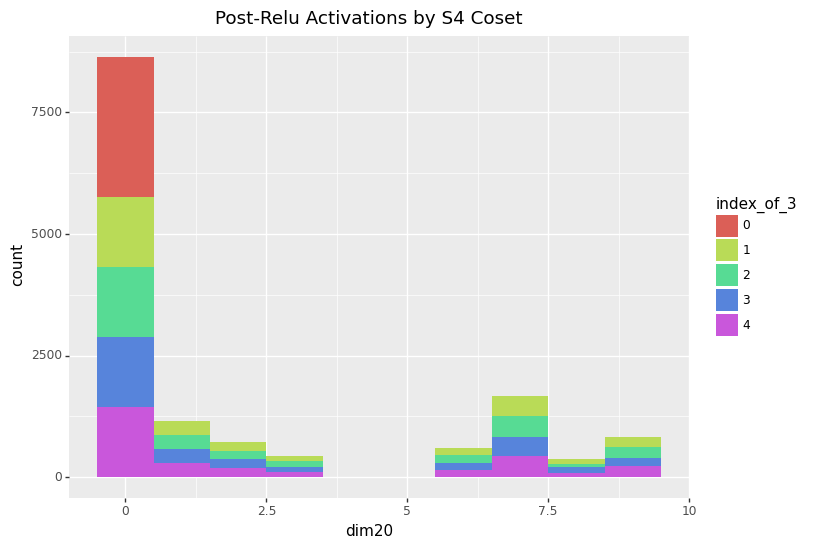

<ggplot: (829897780)>

In [222]:
(
    ggplot(linear_acts_df.with_columns(pl.col('dim20').clip_min(0.0)), aes(x='dim20', fill='index_of_3')) 
    + geom_histogram(binwidth=1)
    + ggtitle('Post-Relu Activations by S4 Coset')
    + theme(figure_size=(8, 6))
)

In [223]:
fmodel, params = functorch.make_functional(model)

In [224]:
from copy import deepcopy

params_copy = deepcopy(params)

In [225]:
from sngrok.fourier import ift_trace

def sn_fourier_decomp(ft, group, device='cpu'):
    permutations = group.elements
    group_order = len(permutations)
    all_irreps = group.irreps()
    for k, v in all_irreps.items():
        all_irreps[k] = v.matrix_representations()
    ift_decomps = {}
    for partition, m in all_irreps.items():
        fourier_decomp = []
        for perm in permutations:
            inv_rep = torch.asarray(m[perm.sigma].T, device=device).squeeze()           
            fourier_decomp.append(ift_trace(ft[partition], inv_rep.to(torch.float32)).unsqueeze(0))
        ift_decomps[partition] = torch.cat(fourier_decomp) / group_order
            
    return ift_decomps

In [49]:
S5 = Symmetric(5)
lembed_ft = slow_sn_ft_1d(params[0], 5)
rembed_ft = slow_sn_ft_1d(params[1], 5)
unembed_ft = slow_sn_ft_1d(params[3], 5)
lembed_decomp = sn_fourier_decomp(lembed_ft, S5)
rembed_decomp = sn_fourier_decomp(rembed_ft, S5)
unembed_decomp = sn_fourier_decomp(unembed_ft, S5)

In [32]:
lembed_decomp[(2, 1, 1, 1)].shape

torch.Size([120, 256])

In [35]:
def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).sum()



In [36]:
eval_loss(fmodel, params, lperms, rperms, targets)

tensor(0.0884, dtype=torch.float64, grad_fn=<SumBackward0>)

In [66]:
params2111 = [deepcopy(p) for p in params]


params2111[0] = lembed_decomp[(2, 1, 1, 1)]
params2111[1] = rembed_decomp[(2, 1, 1, 1)]

eval_loss(fmodel, tuple(params2111), lperms, rperms, targets)

tensor(7757.8630, dtype=torch.float64, grad_fn=<SumBackward0>)

In [65]:
params32 = [deepcopy(p) for p in params]
params32[3] = unembed_decomp[(3, 2)]
eval_loss(fmodel, tuple(params32), lperms, rperms, targets)

tensor(65261.6882, dtype=torch.float64, grad_fn=<SumBackward0>)

In [57]:
params32 = [deepcopy(p) for p in params]


params32[0] = lembed_decomp[(2, 1, 1, 1)]
params32[1] = rembed_decomp[(2, 1, 1, 1)]

eval_loss(fmodel, tuple(params32), lperms, rperms, targets) / 14400

tensor(0.5387, dtype=torch.float64, grad_fn=<DivBackward0>)

In [61]:
params_neg = [deepcopy(p) for p in params]
# this is the linear layer, multiplying the whole thing by negative 1
params_neg[2] = -1. * params[2]
print(eval_loss(fmodel, tuple(params_neg), lperms, rperms, targets))
print(eval_loss(fmodel, params, lperms, rperms, targets))

tensor(0.1876, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0884, dtype=torch.float64, grad_fn=<SumBackward0>)


In [75]:

def ablate_one_column(model_fn, params, index):
    param_copies = [deepcopy(p).detach() for p in params]
    param_copies[3][:, index] = torch.zeros((120,))
    return eval_loss(model_fn, param_copies, lperms, rperms, targets)
    

In [88]:
ablated_losses = np.zeros((128,))
for i in range(128):
    ablated_losses[i] = ablate_one_column(fmodel, params, i)


In [230]:
def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


In [233]:
W = model.linear.weight

S5 = Symmetric(5)

llin_ft = slow_sn_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_sn_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)

llin_fb = sn_fourier_basis(llin_ft, S5)
llin_df = fourier_basis_to_df(llin_fb, 5)

rlin_fb = sn_fourier_basis(rlin_ft, S5)
rlin_df = fourier_basis_to_df(rlin_fb, 5)

In [242]:
from functools import reduce

def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, prefix):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), f'coset_rep_{prefix}': rep} for c in cos])
    return pl.DataFrame(data)


def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)


def make_right_coset_rep_df(subgroups, n):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)


In [243]:
frobenius_groups = {
    "order": 20,
    "copies": 6,
    "generators": [
        [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
        [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
        [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
        [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
        [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
        [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
    ]  
}

In [273]:
frob_coset_list = [generate_subgroup(frob) for frob in frobenius_groups['generators']]
frob_left_df = make_left_coset_rep_df(frob_coset_list, 5)
frob_right_df = make_right_coset_rep_df(frob_coset_list, 5)

In [290]:
a4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
        [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
        [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
        [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
        [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

    ]
}

a4_coset_list = [generate_subgroup(a) for a in a4_subgroups['generators']]
a4_left_df = make_left_coset_rep_df(a4_coset_list, 5)
a4_right_df = make_right_coset_rep_df(a4_coset_list, 5)


In [274]:
left_df = (
    llin_df
    .melt(id_vars=['permutation', 'irrep'])
    .join(frob_right_df, on='permutation', how='inner')
)

right_df = (
    rlin_df
    .melt(id_vars=['permutation', 'irrep'])
    .join(frob_left_df, on='permutation', how='inner')
)


left_df.head()

permutation,irrep,variable,value,coset_rep_0,coset_rep_1,coset_rep_2,coset_rep_3,coset_rep_4,coset_rep_5
str,str,str,f32,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""dim0""",0.012522,"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4..."
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""","""dim0""",-0.143998,"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4..."
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""","""dim0""",-1.417523,"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4..."
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""","""dim0""",0.024593,"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4..."
"""(0, 1, 2, 3, 4...","""(3, 2)""","""dim0""",0.014974,"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4..."


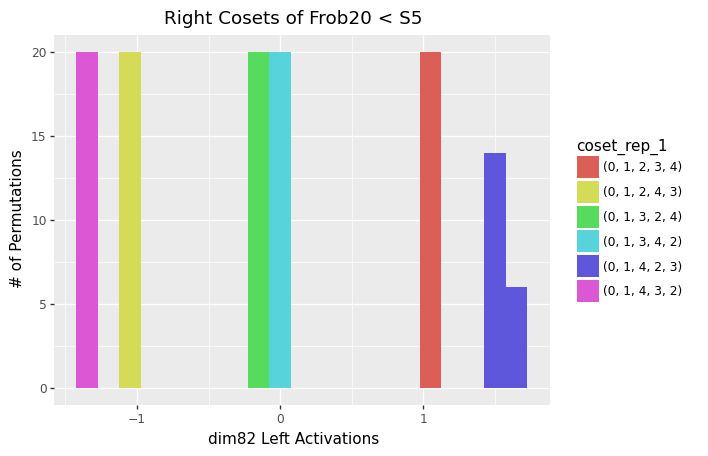

<ggplot: (880318525)>

In [281]:
col = 'dim82'

df = left_df.filter(pl.col('irrep') == '(3, 2)').filter(pl.col('variable') == col)


(
    ggplot(df, aes(x='value', fill='coset_rep_1')) 
    + geom_histogram(binwidth=0.15)
    + xlab('dim82 Left Activations')
    + ylab('# of Permutations')
    + ggtitle('Right Cosets of Frob20 < S5')
)

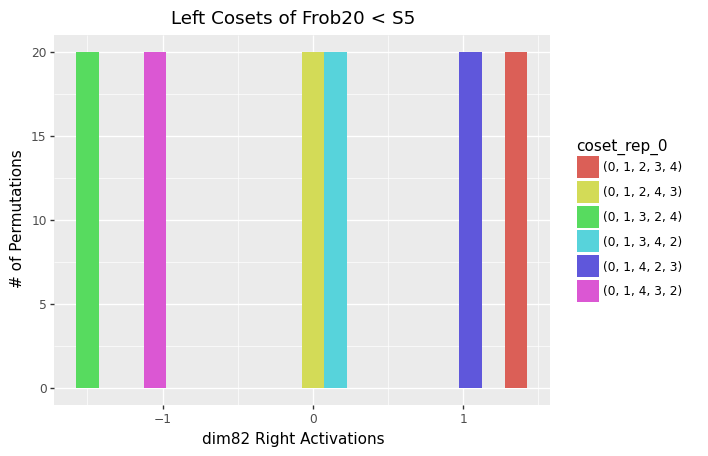

<ggplot: (897268604)>

In [286]:
col = 'dim82'

df = right_df.filter(pl.col('irrep') == '(3, 2)').filter(pl.col('variable') == col)


(
    ggplot(df, aes(x='value', fill='coset_rep_0')) 
    + geom_histogram(binwidth=0.15)
    + xlab('dim82 Right Activations')
    + ylab('# of Permutations')
    + ggtitle('Left Cosets of Frob20 < S5')
)

In [226]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

W = model.linear.weight

lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

In [288]:
(
    lpower_df
    .melt(id_vars='irrep')
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .filter(pl.col('value') > 0.2)
    .filter(pl.col('value') < 0.8)
)

irrep,variable,value
str,str,f32
"""(2, 1, 1, 1)""","""dim2""",0.290886
"""(2, 1, 1, 1)""","""dim9""",0.210131
"""(2, 1, 1, 1)""","""dim43""",0.716484
"""(2, 1, 1, 1)""","""dim59""",0.227522
"""(2, 1, 1, 1)""","""dim60""",0.256835
"""(2, 1, 1, 1)""","""dim101""",0.6903


In [289]:
rpower_df.select(['irrep', 'dim60'])

irrep,dim60
str,f32
"""(1, 1, 1, 1, 1...",0.003649
"""(2, 1, 1, 1)""",0.301927
"""(2, 2, 1)""",0.032542
"""(3, 1, 1)""",0.050394
"""(3, 2)""",0.060063
"""(4, 1)""",0.535113
"""(5,)""",0.016312


In [ ]:
left_df = (
    llin_df
    .melt(id_vars=['permutation', 'irrep'])
    .join(a4_right_df, on='permutation', how='inner')
)

right_df = (
    rlin_df
    .melt(id_vars=['permutation', 'irrep'])
    .join(a4_left_df, on='permutation', how='inner')
)




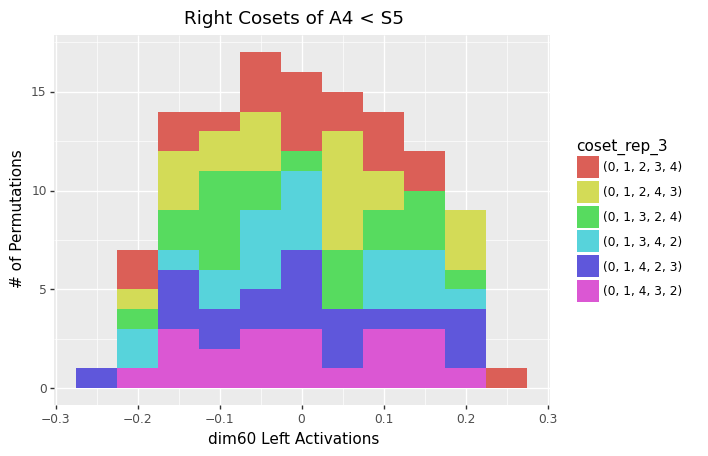

<ggplot: (897411877)>

In [296]:
col = 'dim60'

df = left_df.filter(pl.col('irrep') == '(4, 1)').filter(pl.col('variable') == col)


(
    ggplot(df, aes(x='value', fill='coset_rep_3')) 
    + geom_histogram(binwidth=0.05)
    + xlab('dim60 Left Activations')
    + ylab('# of Permutations')
    + ggtitle('Right Cosets of A4 < S5')
)

In [109]:
df = (
    lpower_df
    .melt(id_vars='irrep')
    .sort('value')
    .groupby('variable')
    .agg([pl.col('irrep').last(), pl.col('value').max()])
    .sort('variable')
)
df

variable,irrep,value
str,str,f32
"""dim0""","""(2, 2, 1)""",0.942331
"""dim1""","""(2, 1, 1, 1)""",0.999838
"""dim10""","""(3, 2)""",0.899537
"""dim100""","""(2, 1, 1, 1)""",0.999996
"""dim101""","""(2, 1, 1, 1)""",0.6903
"""dim102""","""(4, 1)""",0.893877
"""dim103""","""(2, 1, 1, 1)""",0.999956
"""dim104""","""(2, 1, 1, 1)""",0.997918
"""dim105""","""(2, 1, 1, 1)""",0.958471


In [110]:
ablation_df = pl.DataFrame({'ablation_loss': ablated_losses, 'dim': [f'dim{i}' for i in range(128)]})
ablation_df = ablation_df.join(df, left_on='dim', right_on='variable', how='inner')

In [111]:
ablation_df

ablation_loss,dim,irrep,value
f64,str,str,f32
0.095213,"""dim0""","""(2, 2, 1)""",0.942331
44.164559,"""dim1""","""(2, 1, 1, 1)""",0.999838
0.089468,"""dim10""","""(3, 2)""",0.899537
311.308014,"""dim100""","""(2, 1, 1, 1)""",0.999996
0.088358,"""dim101""","""(2, 1, 1, 1)""",0.6903
0.093144,"""dim102""","""(4, 1)""",0.893877
8.752068,"""dim103""","""(2, 1, 1, 1)""",0.999956
0.334863,"""dim104""","""(2, 1, 1, 1)""",0.997918
0.088767,"""dim105""","""(2, 1, 1, 1)""",0.958471


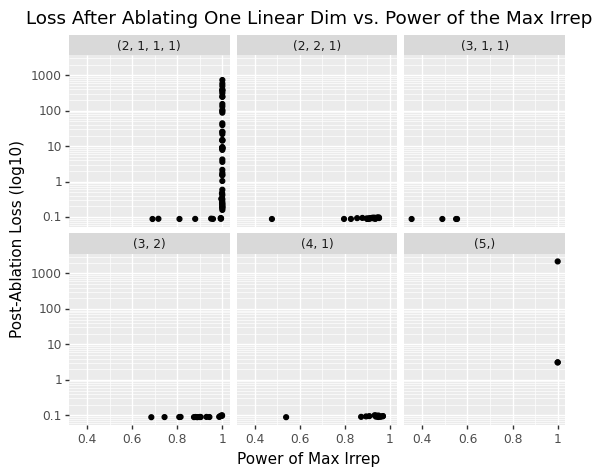

<ggplot: (773544291)>

In [116]:
from plotnine import scale_y_log10

(
    ggplot(
        ablation_df,
        aes(x = 'value', y='ablation_loss')
    ) 
    + geom_point() 
    + facet_wrap('~irrep') 
    + scale_y_log10()
    + xlab('Power of Max Irrep')
    + ylab('Post-Ablation Loss (log10)')
    + ggtitle('Loss After Ablating One Linear Dim vs. Power of the Max Irrep')
)

In [125]:
from torch.nn.functional import relu




tensor([0.4812, 2.5575, 0.0498, 0.4936, 0.0382, 0.3085, 2.1559, 1.7670, 3.1559,
        0.2206, 0.2067, 0.2913, 1.8553, 3.3694, 0.2118, 0.3923, 0.4318, 3.2536,
        2.8052, 3.1725, 2.0217, 0.1813, 1.3201, 0.1163, 2.7131, 0.5623, 0.1660,
        1.5112, 0.1962, 2.7400, 0.4894, 0.2726, 0.0636, 0.5145, 0.4629, 2.1122,
        2.1739, 1.9512, 0.4747, 1.7497, 0.5445, 2.9931, 2.1876, 0.3696, 0.2208,
        0.3818, 1.3088, 0.2542, 2.1189, 0.2414, 0.3592, 3.3327, 1.4136, 0.6727,
        0.3616, 1.4134, 0.3620, 0.1213, 0.4011, 0.0892, 0.1073, 0.2226, 3.5111,
        1.5346, 0.1342, 0.1114, 0.4570, 0.4791, 2.2091, 0.4217, 2.7376, 2.5002,
        2.0597, 1.8745, 0.2483, 1.8743, 1.3405, 2.8368, 2.6987, 0.4367, 0.5921,
        0.5033, 0.5830, 0.4878, 3.2235, 1.7455, 0.2262, 0.4057, 0.3066, 0.5130,
        3.0339, 2.3888, 0.4099, 1.6435, 0.4873, 0.5399, 2.0430, 3.3002, 0.3515,
        0.5113, 3.2679, 0.0917, 0.3980, 2.1154, 1.2378, 0.2539, 0.4159, 1.6673,
        0.3489, 2.0678, 2.9959, 0.2893, 

In [130]:
act_means = relu(linear_acts).mean(dim=0)
acts = deepcopy(linear_acts)

In [160]:
preactivations = deepcopy(linear_acts)

In [164]:
# Normal state of things
grokked_loss = loss_fn(model.unembed(relu(preactivations)), targets).sum()
# Tweaked circuit
abs_loss = loss_fn(model.unembed(preactivations.abs()), targets).sum()
print(f"Fully grokked model: {grokked_loss}")
print(f"Activations only 0 if the pre-activations are 0: {abs_loss}")

Fully grokked model: 0.08836323683800329
Activations only 0 if the pre-activations are 0: 9.768129726456845e-07


In [149]:
def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()
    

In [ ]:
def zero_ablate_one_column(model, linear_activations, index):
        
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = torch.zeros((acts.shape[0],))
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()
    

In [150]:
mean_ablations = torch.zeros((128,))
for i in range(128):   
    mean_ablations[i] = mean_ablate_one_column(model, linear_acts, i)

    

In [151]:
loss_fn(model.unembed(linear_acts), targets).sum()

tensor(88411.2850, dtype=torch.float64, grad_fn=<SumBackward0>)

In [153]:
ablation_df.insert_at_idx(0, pl.Series('mean_ablation_loss', mean_ablations.detach().numpy()))
ablation_df = ablation_df.rename({'ablation_loss': 'zero_ablation_loss'})

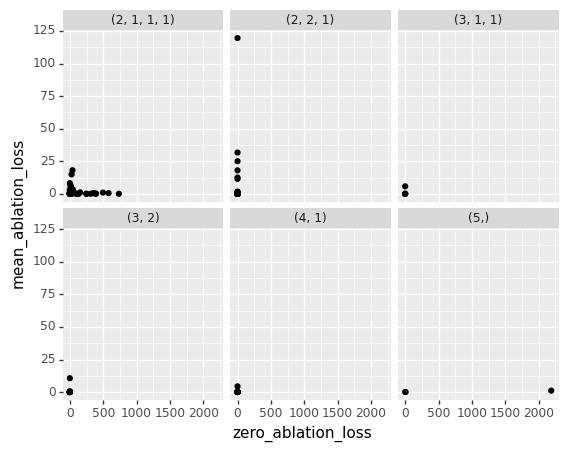

<ggplot: (685664088)>

In [155]:
ggplot(ablation_df, aes(x = 'zero_ablation_loss', y = 'mean_ablation_loss')) + geom_point() + facet_wrap('~irrep')

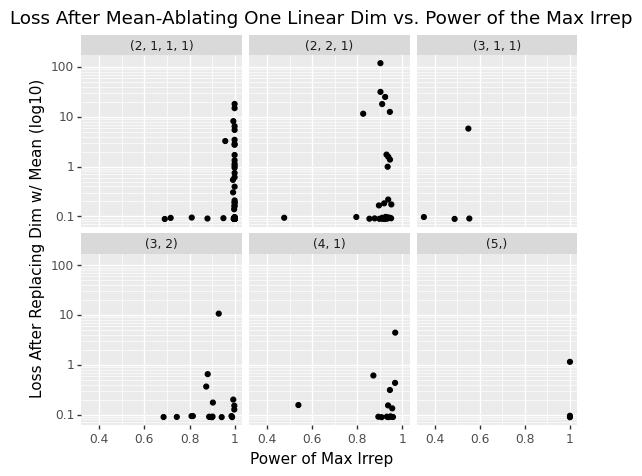

<ggplot: (688753322)>

In [156]:
(
    ggplot(
        ablation_df,
        aes(x = 'value', y='mean_ablation_loss')
    ) 
    + geom_point() 
    + facet_wrap('~irrep') 
    + scale_y_log10()
    + xlab('Power of Max Irrep')
    + ylab('Loss After Replacing Dim w/ Mean (log10)')
    + ggtitle('Loss After Mean-Ablating One Linear Dim vs. Power of the Max Irrep')
)